In [26]:
import pandas as pd
import os
import fnmatch
from PIL import Image
from transformers import (
    ViTImageProcessor ,
    ViTModel,
    ImageClassificationPipeline
)
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from qdrant_client import QdrantClient, models
from qdrant_client.models import VectorParams, Distance
load_dotenv()

pretrained_model_name = 'google/vit-base-patch16-224-in21k'

In [27]:
processor  = ViTImageProcessor.from_pretrained(pretrained_model_name)
model = ViTModel.from_pretrained(
    pretrained_model_name,
)


In [28]:
test  = [Image.open("../patch.png").convert("RGB")]

try:
    test_inputs = processor(test, return_tensors="pt")
    test_outputs = model(**test_inputs)
except Exception as e:
    print(e)
embeddings = test_outputs.last_hidden_state[:, 0, :]  # Take CLS token embedding

# Convert to list
test_embeddings = embeddings.detach().numpy().tolist()

In [29]:
test_embeddings

[[-0.1063530296087265,
  -0.11173568665981293,
  -0.15598206222057343,
  -0.023095767945051193,
  -0.26424890756607056,
  -0.47092437744140625,
  -0.05911007151007652,
  0.08381606638431549,
  -0.23563773930072784,
  -0.3667282462120056,
  0.1636374592781067,
  0.11658395826816559,
  0.47964948415756226,
  -0.38808515667915344,
  0.008544820360839367,
  0.10841729491949081,
  0.40050551295280457,
  0.009458048269152641,
  0.2077275514602661,
  0.04776753485202789,
  -0.06813030689954758,
  0.24452084302902222,
  0.18671007454395294,
  -0.20425456762313843,
  -0.013276692479848862,
  -0.004118937999010086,
  -0.19095540046691895,
  -0.15460512042045593,
  0.27441835403442383,
  -0.31750860810279846,
  0.11916394531726837,
  0.2234456092119217,
  0.35043051838874817,
  0.24024197459220886,
  -0.21653491258621216,
  -0.15742912888526917,
  -0.47842147946357727,
  -0.21967557072639465,
  -0.1099226102232933,
  -0.014981487765908241,
  0.1995561122894287,
  0.020801102742552757,
  -0.125191

In [30]:
len(test_embeddings[0])

768

In [31]:
qclient = QdrantClient(
    url=os.getenv("QDRANT_CLUSTER"),
    api_key=os.getenv("QDRANT_API_KEY")
)

qclient

In [32]:
qclient.scroll("shoeprints_part1")

([Record(id=0, payload={'ID': '001_01', 'Gender': 'W', 'Brand': 'Converse', 'Model/Details': None, 'Size': 5.5, 'image_url': 'Part1/001_01_R_05.tiff'}, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload={'ID': '002_01', 'Gender': 'M', 'Brand': 'Saucony', 'Model/Details': 'cohesion_xt600', 'Size': 9.5, 'image_url': 'Part1/002_01_R_05.tiff'}, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload={'ID': '002_02', 'Gender': 'M', 'Brand': 'Saucony', 'Model/Details': 'ride5', 'Size': 9.5, 'image_url': 'Part1/002_02_R_05.tiff'}, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload={'ID': '002_05', 'Gender': 'M', 'Brand': 'Saucony', 'Model/Details': 'stratos4', 'Size': 9.5, 'image_url': 'Part1/002_05_R_05.tiff'}, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload={'ID': '002_06', 'Gender': 'M', 'Brand': 'Saucony', 'Model/Details': 'phantom', 'Size': 9.5, 'image_url': 'Part1/002_06_R_05.tiff'}, vector=None, shard_key=Non

In [33]:
search_result = qclient.query_points("shoeprints_part1", query=test_embeddings[0])

In [34]:
search_result

QueryResponse(points=[ScoredPoint(id=13, version=0, score=0.1256067, payload={'ID': '004_07', 'Gender': 'M', 'Brand': 'Asics', 'Model/Details': 'GEL-sonoma2', 'Size': 9.5, 'image_url': 'Part1/004_07_R_05.tiff'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=3, version=0, score=0.113007866, payload={'ID': '002_05', 'Gender': 'M', 'Brand': 'Saucony', 'Model/Details': 'stratos4', 'Size': 9.5, 'image_url': 'Part1/002_05_R_05.tiff'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=5, version=0, score=0.11184142, payload={'ID': '002_07', 'Gender': 'M', 'Brand': 'Saucony', 'Model/Details': 'guide9', 'Size': 9.5, 'image_url': 'Part1/002_07_R_05.tiff'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=4, version=0, score=0.106309146, payload={'ID': '002_06', 'Gender': 'M', 'Brand': 'Saucony', 'Model/Details': 'phantom', 'Size': 9.5, 'image_url': 'Part1/002_06_R_05.tiff'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=9, version=0, s

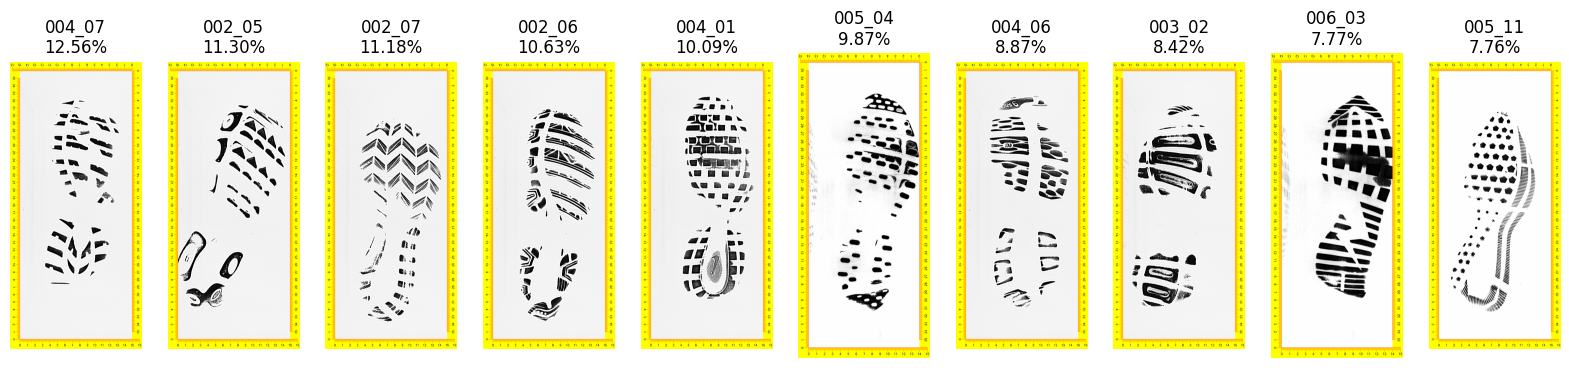

In [35]:
def return_retrived_image(search_result):
    fig, axes = plt.subplots(1, len(search_result.points), figsize=(20, 5))
    for ax, point in zip(axes, search_result.points):
        img = Image.open(point.payload["image_url"]).convert("RGB")
        ax.imshow(img)
        ax.set_title(point.payload["ID"] + f"\n{point.score*100:.2f}%")
        ax.axis('off')
    plt.show()

return_retrived_image(search_result)

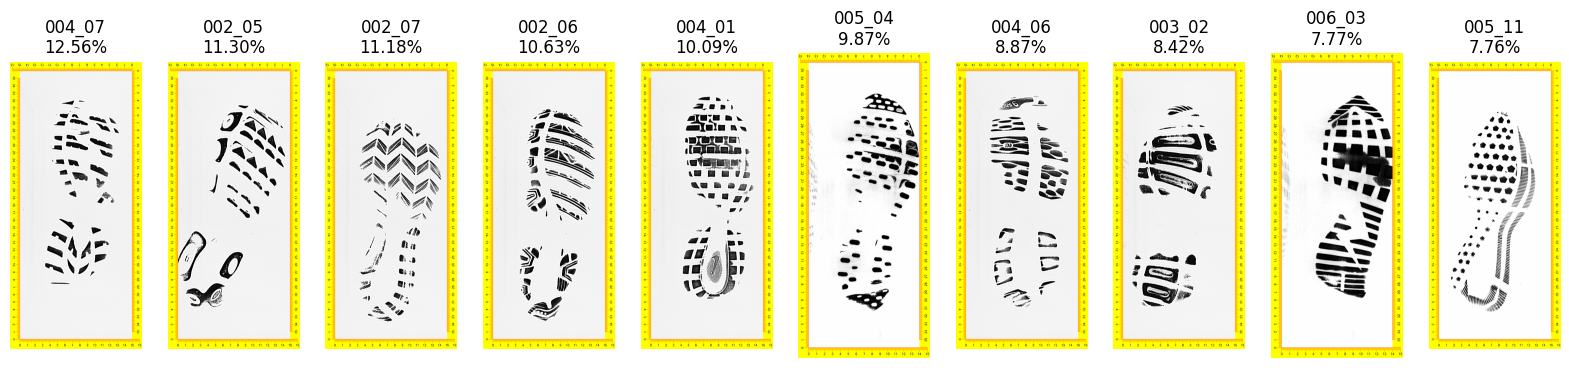

In [36]:
test  = [Image.open("../patch.png").convert("RGB")]

try:
    test_inputs = processor(test, return_tensors="pt")
    test_outputs = model(**test_inputs)
except Exception as e:
    print(e)
embeddings = test_outputs.last_hidden_state[:, 0, :]  # Take CLS token embedding

# Convert to list
test_embeddings = embeddings.detach().numpy().tolist()
search_result = qclient.query_points("shoeprints_part1", query=test_embeddings[0])
return_retrived_image(search_result)

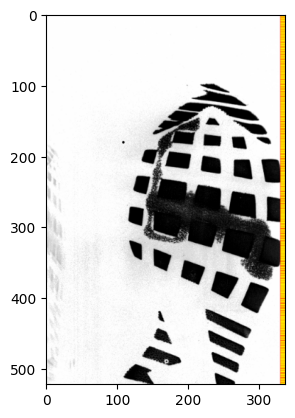

In [37]:
plt.imshow(test[0])